<a href="https://colab.research.google.com/github/pbenito1/TFM/blob/main/CZDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicción contra dominios `.COM` del servicio CZDS

El servicio CZDS de [ICANN](https://czds.icann.org/home) proporciona el listado de los dominios de una gran parte de los dominios TLD disponibles.

Entre ellos, se encuentra el TLD más popular, el "_.com_" que cuenta en la actualidad con casi 160 millones de dominios, y del que se crean diariamente [más de 100.000 dominios](https://dnpedia.com/tlds/daily.php).

En este experimento vamos a realizar la predicción de bondad del listado de dominios .com de acuerdo a los modelos entrenados en las fases anteriores del TFM.

## Pretratamiento de dominios `.com``

El listado de dominios `.com` proporcionado por ICANN se proporciona en forma de un archivo denominado `com.txt.gz` que contiene un único archivo `com.txt` con el siguiente contenido:

```
com.    900     in      soa     a.gtld-servers.net.     nstld.verisign-grs.com. 1664841622      1800    900     604800  86400
0-------------------------------------------------------------0.com.    172800  in      ns      ns1.domainit.com.
0-------------------------------------------------------------0.com.    172800  in      ns      ns2.domainit.com.
0-------------------------------------------------------------5.com.    172800  in      ns      fns.frogsmart.net.
0-------------------------------------------------------------5.com.    172800  in      ns      sns.frogsmart.net.
0-------------------------------------------------------------5.com.    172800  in      ns      tns.frogsmart.net.
0---------------------0.com.    172800  in      ns      ns0.directnic.com.
0---------------------0.com.    172800  in      ns      ns1.directnic.com.
```

En el mismo se puede observar que contiene no únicamente los dominios registrados, sino los servidores de nombre asociados. Realmente de esa información, en nuestro caso, únicamente nos interesa el nombre de dominio. Por este motivo es necesario realizar un pretratamiento para filtrar, exclusivamente, los dominios `.com` únicos.

Este tratamiento lo realizamos mediante los siguientes comandos en `bash` de Linux:

Descomprimimos el archivo, nos quedamos con la primera columna y deduplicamos los dominios utilizando el comando `uniq`:
```
$ gunzip -c com.txt.gz|cut -f1|uniq|more>com_domains.txt
```

Eliminamos los dominios `unicode`, comienzan por `xn--`:
```
$ grep -v '^xn--' com_domains.txt >com_domains_uniq_noxnn.txt
```

Extraemos el SLD:
```
$ cat com_domains_uniq_noxnn.txt | rev | cut -d'.' -f3 | rev >com_domains_tld.txt
```

Calculamos el número de dominios:
```
$ wc -l com_domains_tld.txt
165107972 com_domains_tld.txt
```

Hay más de 165 millones de dominios `.com`


A continuación cargaremos el modelo CNN previamente entrenado en el _notebook_ de [Redes neuronales](RedesNeuronales.ipynb), y realizaremos las predicciones de parte de los dominios `.com`. Dado que existen limitaciones de memoria en el servicio Google Colab, se realizarán las predicciones únicamente sobre 10 millones de registros de CZDS.


In [43]:
# imports
import os
import tensorflow as tf
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
# Cargamos el modelo CNN
GDRIVE_PATH='/content/drive/MyDrive/TFM'
CHECKPOINTS_PATH=os.path.join(GDRIVE_PATH, 'checkpoints')

Cargamos el modelo entrenado previamente

In [4]:
model = tf.keras.models.load_model(os.path.join(GDRIVE_PATH,'CONV1D'))

Cargamos el mapeo de caracteres previamente serializado

In [5]:
with open(os.path.join(GDRIVE_PATH, 'valid_chars.pickle'), 'rb') as h:
  valid_chars=pickle.load(h)

Cargamos el archivo preprocesado con los dominios `.com` de CZDS. 

Por limitaciones de memoria únicamente cargamos 20 millones de elementos. De ellos tomamos una muestra de 100.000 elementos

In [25]:
df = pd.read_csv(os.path.join(GDRIVE_PATH,'CZDS/com_domains_tld.txt'),header=None,names=['domain'],nrows=20000000)
df=df.sample(100000)

Añadimos el TLD `.com`. La red neuronal toma como parámetro el dominio completo, incluyendo TLD.

In [26]:
df['full_domain'] = df['domain'].apply(lambda d:d+'.com')

In [27]:
X = np.array(df['full_domain'])

Mapeamos los caracteres a su código numérico asociado

In [28]:
X = [[valid_chars[y] for y in x] for x in X]

Añadimos _padding_ hasta la máxima longitud del dominio (67)

In [29]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=67)

In [30]:
p=model.predict(X)

3125/3125 [==============================] - 5s 2ms/step


Las predicciones menores de 0.5 se consideran benignas y las mayores, malignas.

In [31]:
Y = np.array(['benign' if x <0.5 else 'malign' for x in p])

Añadimos los resultados al _dataframe_ original

In [32]:
np.concatenate( p, axis=0 )
df['category'] = Y.tolist()
df['prediction'] = np.concatenate( p, axis=0 )

Muestra de **dominios benignos**. Se toman los valores de predicción más cercanos a 0, los cuales son más representativos:

In [33]:
#df[df.category=='benign'].sample(10)
df[df.prediction<0.01].sample(10)

,domain,full_domain,category,prediction
7373020,ack-x,ack-x.com,benign,1.964372e-08
15359269,atacross,atacross.com,benign,8.551880e-03
19073299,beautybarbyford,beautybarbyford.com,benign,1.989538e-03
2530270,360integrations,360integrations.com,benign,4.683399e-04
1731003,22plus,22plus.com,benign,1.969252e-04
11906847,amyfranko,amyfranko.com,benign,5.020640e-03
13393429,applecan,applecan.com,benign,6.389543e-03
13099224,aotrader,aotrader.com,benign,3.696646e-03
16988821,azurespins,azurespins.com,benign,5.288416e-03
19529933,belle-rep,belle-rep.com,benign,6.843436e-06


Muestra de **dominios malignos**. Se toman los valores de predicción más cercanos a 1, los cuales son más representativos:

In [34]:
#df[df.category=='malign'].sample(10)
df[df.prediction>0.95].sample(10)

,domain,full_domain,category,prediction
2888294,3m7speealie0eal26gfj42g1sao35in8,3m7speealie0eal26gfj42g1sao35in8.com,malign,0.999878
4681903,6pukv660oaqhmtjf557sa1m78e1kivcf,6pukv660oaqhmtjf557sa1m78e1kivcf.com,malign,1.000000
2904273,3nc55meacriuvrf8i4l9sendgaosi728,3nc55meacriuvrf8i4l9sendgaosi728.com,malign,0.999989
6236933,9jl0u1r950bb2v5nsoahuea19m3sjkr2,9jl0u1r950bb2v5nsoahuea19m3sjkr2.com,malign,1.000000
5669325,8i0mcco6ktlflpk6830p3lsn4ned75ql,8i0mcco6ktlflpk6830p3lsn4ned75ql.com,malign,1.000000
2609731,36gtopb1leoqjn7kdp9ck9kp9aojaacg,36gtopb1leoqjn7kdp9ck9kp9aojaacg.com,malign,1.000000
6479157,a7q27556abg845mammt35u4mv52bj4sp,a7q27556abg845mammt35u4mv52bj4sp.com,malign,0.999996
5092303,7fhpjgl320q3acbeul4vqp3ta1djnhq4,7fhpjgl320q3acbeul4vqp3ta1djnhq4.com,malign,1.000000
2956333,3s32eo6a9g0ub1ql11haunnu88ni44a0,3s32eo6a9g0ub1ql11haunnu88ni44a0.com,malign,0.999999
2469357,347ssckobk8o7macvurrkvjaifniuqqa,347ssckobk8o7macvurrkvjaifniuqqa.com,malign,0.999999


Los dominios malignos, aparentemente, tienen apariencia de DGA.

Veamos a continuación cuantos de los dominios se consideran benignos y cuantos malignos:

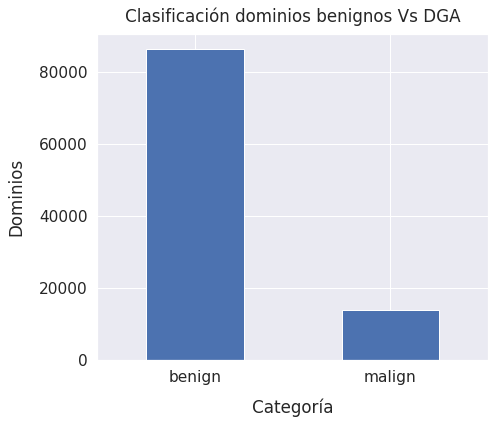

In [45]:
df['category'].value_counts(ascending=False).plot(kind='bar')

sns.set(font_scale=1.4)
df['category'].value_counts(ascending=False).plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Categoría", labelpad=14)
plt.ylabel("Dominios", labelpad=14)
plt.title("Clasificación dominios benignos Vs DGA", y=1.02);